In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [2]:
trips19 = pd.read_csv('tripdata_2019-05.csv')

In [3]:
trips20 = pd.read_csv('tripdata_2020-05.csv')

/home/khodor/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# для того, чтобы не засорять оперативу непонятными данными, удалим их на время
del_columns = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'extra', 'mta_tax', 'tip_amount', 'improvement_surcharge', 'congestion_surcharge']
trips19 = trips19.drop(columns=del_columns)
trips20 = trips20.drop(columns=del_columns)

Посмотрим, какие пропущенные значения есть в данных.

In [5]:
for el in trips19.columns:
    print(el, trips19[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 0
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 0
fare_amount 0
tolls_amount 0
total_amount 0


In [6]:
for el in trips20.columns:
    print(el, trips20[el].isna().sum())

tpep_pickup_datetime 0
tpep_dropoff_datetime 0
passenger_count 58891
trip_distance 0
PULocationID 0
DOLocationID 0
payment_type 58891
fare_amount 0
tolls_amount 0
total_amount 0


На данный момент из пропущенных данных для нас интерес может представлять только колонка о количестве пассажиров.

Посмотрим на самое частое значение и заменим на него все пропущенные значения.

In [7]:
max_passengers_count = trips20['passenger_count'].value_counts().idxmax()
print("Max passengers count = ", max_passengers_count)
trips20.passenger_count = trips20.passenger_count.fillna(max_passengers_count)

Max passengers count =  1.0


Посмотрим на количество колонок, в которых встречаются данные со значением Nan.

Преобразуем формат ячеек с временем для удобства.

In [8]:
trips19['tpep_pickup_datetime'] = pd.to_datetime(trips19.tpep_pickup_datetime)
trips19['tpep_dropoff_datetime'] = pd.to_datetime(trips19.tpep_dropoff_datetime)

In [9]:
trips20['tpep_pickup_datetime'] = pd.to_datetime(trips20.tpep_pickup_datetime)
trips20['tpep_dropoff_datetime'] = pd.to_datetime(trips20.tpep_dropoff_datetime)

Удалим данные, в которых начало во времени находится после конца, а также те строки, в которых id районов посадки/высадки больше 263(их именно столько).

In [10]:
trips19 = trips19[trips19.tpep_pickup_datetime <= trips19.tpep_dropoff_datetime]
trips19 = trips19[trips19.PULocationID <= 263]

In [11]:
trips20 = trips20[trips20.tpep_pickup_datetime <= trips20.tpep_dropoff_datetime]
trips20 = trips20[trips20.PULocationID <= 263]

Введём новые колонки: 

1. с датой начала поездки; 

2. с часом начала и конца;

3. с днём недели начала поездки; 

4. с временем продолжительности поездки(день конца поездки игнорируем, т.к. почти все поездки будут в промежутке одного дня);

5. временем поездки в секундах;

6. средней скоростью в м/с.

In [12]:
MILES_TO_KM = 1609.34

In [13]:
trips19['trip_pickup_day'] = trips19.tpep_pickup_datetime.dt.day
trips19['week_day'] = trips19.tpep_pickup_datetime.dt.dayofweek
trips19['trip_pickup_hour'] = trips19.tpep_pickup_datetime.dt.hour
trips19['trip_dropoff_hour'] = trips19.tpep_dropoff_datetime.dt.hour
trips19['trip_duration'] = trips19.tpep_dropoff_datetime - trips19.tpep_pickup_datetime
trips19['trip_duration_secs'] = trips19.trip_duration.dt.seconds
trips19['average_velocity'] = (trips19['trip_distance'] * MILES_TO_KM) / trips19['trip_duration_secs']

In [14]:
trips20['trip_pickup_day'] = trips20.tpep_pickup_datetime.dt.day
trips20['week_day'] = trips20.tpep_pickup_datetime.dt.dayofweek
trips20['trip_pickup_hour'] = trips20.tpep_pickup_datetime.dt.hour
trips20['trip_dropoff_hour'] = trips20.tpep_dropoff_datetime.dt.hour
trips20['trip_duration'] = trips20.tpep_dropoff_datetime - trips20.tpep_pickup_datetime
trips20['trip_duration_secs'] = trips20.trip_duration.dt.seconds
trips20['average_velocity'] = (trips20['trip_distance'] * MILES_TO_KM) / trips20['trip_duration_secs']

Посмотрим, есть ли в данных нереальные случаи.

Установим ограничение для средней скорости в 162 км/ч(45 м/с) сверху и 2(м/с) снизу, а также удалим строки, в которых преодолено нулевое расстояние за ненулевое время, при этом получена некоторая сумма за поездку.

Так же удалим строки с отрицательной стоимостью поездки.

In [15]:
trips19 = trips19[trips19.average_velocity <= 45]
trips19 = trips19[trips19.average_velocity > 2]
trips19 = trips19.drop(trips19[(trips19.trip_distance == 0) & (trips19.total_amount > 0) & (trips19.trip_duration_secs > 0)].index)
trips19 = trips19[trips19.total_amount >= 0]

In [16]:
trips20 = trips20[trips20.average_velocity <= 45]
trips20 = trips20[trips20.average_velocity > 2]
trips20 = trips20.drop(trips20[(trips20.trip_distance == 0) & (trips20.total_amount > 0) & (trips20.trip_duration_secs > 0)].index)
trips20 = trips20[trips20.total_amount >= 0]

Посмотрим на некоторые статистики данных, которые может предоставить python.

In [17]:
trips19.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7.030684e+06,7030684,7.030684e+06,7.030684e+06
mean,1.572756e+00,3.166597e+00,1.623793e+02,1.607376e+02,1.277294e+00,1.347646e+01,4.199666e-01,1.963256e+01,1.543946e+01,3.012786e+00,1.398643e+01,1.402329e+01,0 days 00:14:58.874266,8.988743e+02,5.188255e+00
std,1.222698e+00,4.012323e+00,6.603892e+01,7.042278e+01,4.622874e-01,1.201215e+01,1.805476e+00,1.490204e+01,8.939546e+00,1.857191e+00,6.093207e+00,6.186246e+00,0 days 00:12:35.086851,7.550869e+02,2.698139e+00
min,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0 days 00:00:01,1.000000e+00,2.000008e+00
25%,1.000000e+00,1.030000e+00,1.140000e+02,1.070000e+02,1.000000e+00,6.500000e+00,0.000000e+00,1.130000e+01,8.000000e+00,2.000000e+00,1.000000e+01,1.000000e+01,0 days 00:06:47,4.070000e+02,3.386320e+00
50%,1.000000e+00,1.730000e+00,1.610000e+02,1.620000e+02,1.000000e+00,9.500000e+00,0.000000e+00,1.480000e+01,1.500000e+01,3.000000e+00,1.500000e+01,1.500000e+01,0 days 00:11:21,6.810000e+02,4.493081e+00
75%,2.000000e+00,3.230000e+00,2.330000e+02,2.340000e+02,2.000000e+00,1.500000e+01,0.000000e+00,2.130000e+01,2.300000e+01,4.000000e+00,1.900000e+01,1.900000e+01,0 days 00:18:49,1.129000e+03,6.114988e+00
max,9.000000e+00,2.632100e+02,2.630000e+02,2.650000e+02,4.000000e+00,4.016500e+03,9.210600e+02,4.020300e+03,3.100000e+01,6.000000e+00,2.300000e+01,2.300000e+01,0 days 06:26:33,2.319300e+04,4.499230e+01


In [18]:
trips20.describe()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,tolls_amount,total_amount,trip_pickup_day,week_day,trip_pickup_hour,trip_dropoff_hour,trip_duration,trip_duration_secs,average_velocity
count,331357.000000,331357.000000,331357.000000,331357.000000,274370.000000,331357.000000,331357.000000,331357.000000,331357.000000,331357.000000,331357.000000,331357.000000,331357,331357.000000,331357.000000
mean,1.267379,3.824966,151.967521,148.053537,1.410497,13.603709,0.436640,18.441833,16.364154,3.003021,13.108430,13.160606,0 days 00:11:55.150583,715.150584,7.514410
std,0.914821,4.733156,70.231915,74.464127,0.529327,12.901901,1.900528,14.350195,8.827310,1.876818,5.307963,5.346439,0 days 00:10:01.541392,601.541393,3.376235
min,0.000000,0.010000,1.000000,1.000000,1.000000,-10.860000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0 days 00:00:02,2.000000,2.000310
25%,1.000000,1.120000,90.000000,75.000000,1.000000,6.000000,0.000000,10.300000,9.000000,1.000000,9.000000,9.000000,0 days 00:05:16,316.000000,5.191419
50%,1.000000,2.080000,142.000000,143.000000,1.000000,9.000000,0.000000,13.800000,16.000000,3.000000,14.000000,14.000000,0 days 00:08:58,538.000000,6.666033
75%,1.000000,4.400000,230.000000,230.000000,2.000000,15.920000,0.000000,20.910000,24.000000,4.000000,17.000000,17.000000,0 days 00:15:25,925.000000,8.898704
max,6.000000,305.100000,263.000000,265.000000,4.000000,819.500000,200.000000,1042.820000,31.000000,6.000000,23.000000,23.000000,0 days 09:02:42,32562.000000,44.395586


### Вот тут ниже надо будет графики в один ряд нарисовать.

In [ ]:
#xparam = 'week_day'
#yparam = 'total_amount'

#pl19 = sns.relplot(
#    data=trips19, x=xparam, y=yparam,
#)
#pl20 = sns.relplot(
#    data=trips20, x=xparam, y=yparam,
#)

#x_lim = max(trips19[xparam].max(), trips20[xparam].max())
#y_lim = max(trips19[yparam].max(), trips20[yparam].max())
#pl19.set(xticks=(0, x_lim), yticks=(0, y_lim))
#pl20.set(xticks=(0, x_lim), yticks=(0, y_lim))

In [19]:
# зададим размер графиков
plt.rcParams['figure.dpi'] = 90

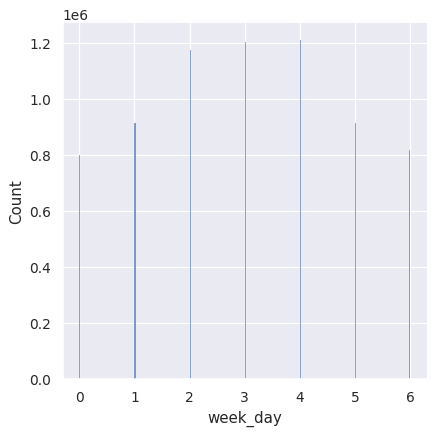

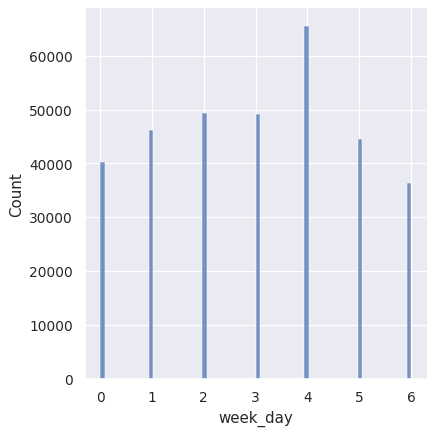

In [20]:
sns.displot(trips19, x='week_day')
sns.displot(trips20, x='week_day')

На графиках выше видим выброс в пятницу в 2020м году. Возможно это объясняется режимом самоизоляции, который очень хочется нарушить в конце рабочей недели(либо в целом возвращение с работы домой, если это не является ежедневной рутиной).

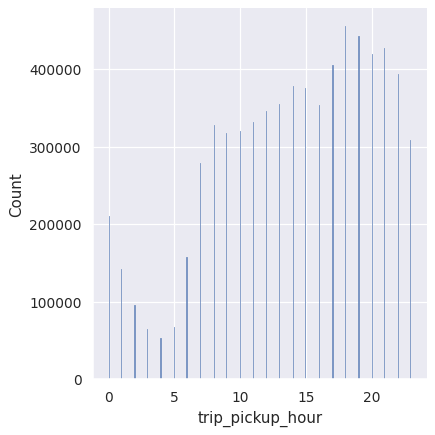

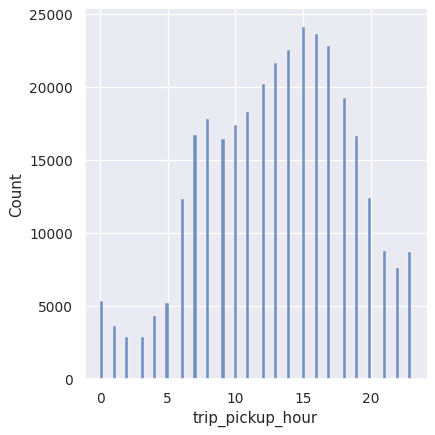

In [21]:
sns.displot(trips19.trip_pickup_hour)
sns.displot(trips20.trip_pickup_hour)

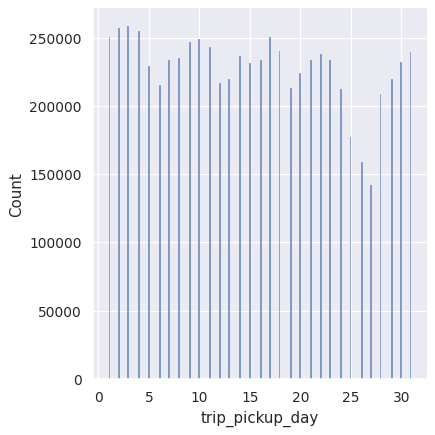

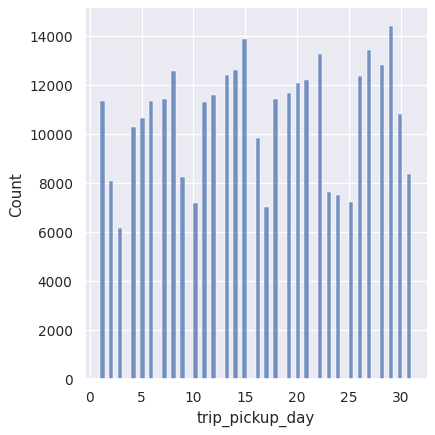

In [22]:
sns.displot(trips19, x='trip_pickup_day')
sns.displot(trips20, x='trip_pickup_day')

(0.0, 5000.0)

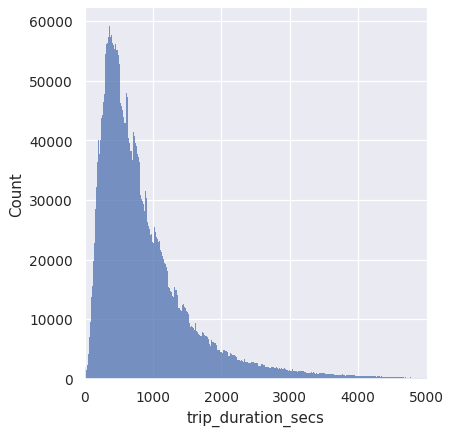

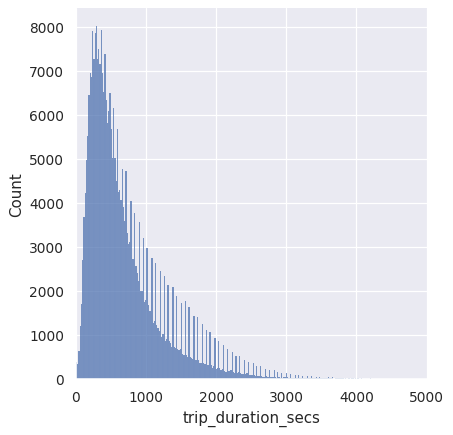

In [31]:
sns.displot(trips19, x='trip_duration_secs')
plt.xlim(0, 5000)
sns.displot(trips20, x='trip_duration_secs')
plt.xlim(0, 5000)
#trips20

Похоже на распределение Пуассона или Максвелла.

На 2м графике существуют видимые выбросы, но это скорее из-за малого количества наблюдений. На 1м графике тенденция видна гораздо лучше и без выбросов.

Легко увидеть, что пользователи совершают очень много коротких поездок(до 30 минут) и очень мало длинных(более часа). На ум приходят две причины: немалая стоимость длинной поездки + средний пассажир(на мой взгляд) ездит ради скорости  и независимости от большинства других факторов(расписание общественного транспорта, движение от точки до точки).

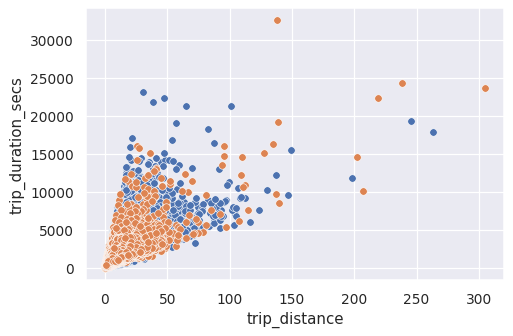

In [47]:
sns.scatterplot(data=trips19, x=trips19['trip_distance'], y=trips19['trip_duration_secs'])
sns.scatterplot(data=trips20, x=trips20['trip_distance'], y=trips20['trip_duration_secs'])

По графикам зависимости времени поездки от расстояния можем понять, что в целом они распределены примерно одинаково относительно друг друга(в целом этому виной например то, как мы убирали выбросы), т.е. эпидемия повлияла в данном случае только на количество поездок и уменьшение числа длительных поездок.